# Recap on the general expressions

## $\dot{r}_i$ contributions

- Accretion disk's torques: 

\begin{equation}
    \dot{r}_\mathrm{gas} = - 2 \Sigma_0 \frac{r^{\gamma + 3/2}}{r_0^\gamma} \frac{G^{1/2} (m_1 + m_2)^{1/2}}{\mu} q^{2} \mathcal{M}^2\text{.}
\end{equation}

- Dark matter spike's dynamical friction:

Static:

\begin{equation}
\label{eq:r_dot_DF}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}}\text{,}
\end{equation}

Time dependent: in this case only the phase has an analytical form, which is derived from the fit of the outcomde of the HaloFeedback code evolving the static dress as the binary evolves. 

\begin{equation}
\label{eq:phi_time}
    \Phi(f) = \Phi_{\mathrm{GW}} \cdot (1 - \eta \cdot y^{-\lambda}(1 - 2F_{1}))
\end{equation}

where the quantities $\eta$, $\lambda$ and $y$ are derived from the frequencies and other constants set in the data (see below for the implementation), while $2F_1$ is the $\textbf{gaussian hypergeometric}$ function, and $\Phi_{\mathrm{GW}}$ is the vacuum phase to coalescence that comes from integrating the below quantity. If we reverse the process to find $\Phi(f)$, it is possible to find an expression for $\dot{r}_{\mathrm{eff, dm}}$, but I will not report it here.


- Gravitational waves: 

\begin{equation}
\label{eq:r_dot_gw}
    \dot{r}_{\mathrm{GW}} = - \frac{64 (m_1 + m_2) G^3 m_1 m_2}{5 c^5 r^3}\text{.}
\end{equation}

In the code, there will be enabled the possibility to choose which of these options to keep in the final formula, which will account for the sum of all the contributions the user requires. 

## Formulas to use and implement "in code" for the phase evaluation

I used the following quantities: 

- Derivative of f in radial separation:

\begin{equation}
\label{eq:dfdr}
    \frac{df}{dr} = \frac{1}{\pi} (-\frac{3}{2}) \sqrt{\frac{G (m_1 + m_2)}{r^5}}\text{.}\\
\end{equation}


- Inverse of f(r):

\begin{equation}
\label{eq:r(f)}
    r(f) = \sqrt[3]{\frac{G (m_1 + m_2)}{\pi^2 f^2}}\text{,}\\
\end{equation}

- Derivative of f in time:

\begin{equation}
\label{eq:dfdt}
    \frac{df}{dt} = \dot{r} \frac{df}{dr}\text{,}\\
\end{equation}

- Second derivative of the phase in time:

\begin{equation}
\label{eq:phi_dot-dot}
    \ddot{\Phi}(f) = 4 \pi^2 f \left(\frac{d\Phi(f)}{df}\right)^{-1} 
\end{equation}

# Code implementation

### Libraries and classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy as sp
from scipy.integrate import quad 
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from tabulate import tabulate
from scipy import interpolate
import matplotlib.colors as mcolors

In [2]:
class Phase_Evaluation:
    
    def __init__(self, m1, m2, mach, sigma0, alpha, gammas, rho6, r6, epsv, dist): 
        
        self.G = 6.67408e-11 # kg^-1 m^3 / s^2
        self.c = 299792458.0 # m / s
        self.m1 = m1
        self.m2 = m2
        self.M_tot = self.m1 + self.m2
        self.mach = mach
        self.r0 = 6 * self.G * self.m1 / self.c**2 # 3 * r_s
        self.mu = self.m1 * self.m2 / (self.m1 + self.m2)
        self.q = self.m2/self.m1
        self.sigma0 = sigma0 / self.mach**2
        self.alpha = alpha
        self.logL = 1 / (self.q)**(1/2)
        self.gammas = gammas
        self.rho6 = rho6
        self.r6 = r6
        self.epsv = epsv
        self.dist = dist
        self.chirp_mass = (self.m1 * self.m2)**(3/5) / (self.M_tot)**(1/5)
    
    
    def rho_dm(self, r):
        '''Finds the density profile of the dark matter using the above formulation.'''
        return self.rho0 * (self.r0 / r)**(self.alpha)
    
    def sigma_acc(self, r): 
        '''Finds the surface density profile of an accretion disk.'''
        return self.sigma0 * (r / self.r0)**(self.alpha)

    def rho_disk(self, r):
        '''Finds the density profile of the disk using \rho \simeq \Sigma(r)/(2h), where h = r / Mach.'''
        return self.sigma_acc(self, r) / (2 * r / self.mach) # set h = r / Mach

    def frequency(self, r):
        '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
        return 1 / np.pi * np.sqrt(self.G * self.m1 / r**3) # m1 not M, corrected from Pippa's notebook
    
    def radius(self, f):
        '''Finds the binary radius assuming circular orbits, at fixed frequency f.'''
        return (self.G * self.M_tot / (np.pi**2 * f**2))**(1/3)

    def df_dr(self, r): 
        '''Finds the binary frequency radial derivative assuming circular orbits.'''
        return 1 / np.pi * (- 3 / 2) * np.sqrt(self.G * self.M_tot / r**5)

    def gas_torque(self, r): 
        '''Finds the gas torque on the secondary.'''
        return - self.sigma_acc(r) * r**4 * (self.G * self.M_tot / r**3) * self.q**2 * self.mach**2

    def yes_or_no(self, elem):
        '''Checks whether you want a contribution or not. (could be made boolean directly)'''
        if elem=='y': 
            return 1
        return 0

    def dot_r(self, r):
        '''Find the binary change in separation over time, asking the user to choose which contribution to keep.'''
            
        acc = ''
        dm = ''
        gw = ''
        
        while(acc != 'y' and acc != 'n'):
            print('Include the accretion contribution? (y/n)')
            acc = input()
        
        while(dm != 'y' and dm != 'n'):
            print('Include the dark matter contribution? (y/n)')
            dm = input()
        
        while(gw != 'y' and gw != 'n'):
            print('Include the GW contribution? (y/n)')
            gw = input()
            
        print('-----')
        
        r_dot_acc = 0.5 * self.gas_torque(r) * self.m2**(-1) * r**(1/2) * (self.G * self.M_tot)**(-1/2)
        
        r_dot_dm = - 8 * np.pi * self.G**(1/2) * self.m2 * self.logL * self.rho6 * self.r6**(self.gammas) * self.epsv / (r**(self.gammas - 5/2) * self.m1 * self.M_tot**(1/2)) 
        
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        
        
        return self.yes_or_no(acc) * r_dot_acc + self.yes_or_no(dm) * r_dot_dm + self.yes_or_no(gw) * r_dot_gw

    def dot_r_acc(self, r):
        
        '''Finds the derivative of radial separation within an accretion disk environment.'''
        
        r_dot_acc = 0.5 * self.gas_torque(r) * self.m2**(-1) * r**(1/2) * (self.G * self.M_tot)**(-1/2)
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        
        return r_dot_gw + r_dot_acc
    
    def dot_r_all(self, r):
        
        '''Finds the derivative of radial separation within a mixed environment.'''
        
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        r_dot_dm = - 8 * np.pi * self.G**(1/2) * self.m2 * self.logL * self.rho6 * self.r6**(self.gammas) * self.epsv / (r**(self.gammas - 5/2) * self.m1 * self.M_tot**(1/2)) 
        r_dot_acc = 0.5 * self.gas_torque(r) * self.m2**(-1) * r**(1/2) * (self.G * self.M_tot)**(-1/2)
        
        return r_dot_gw + r_dot_dm + r_dot_acc
        
    def dot_r_dm(self, r):
        
        '''Finds the derivative of radial separation within a DM environment.'''
        
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        r_dot_dm = - 8 * np.pi * self.G**(1/2) * self.m2 * self.logL * self.rho6 * self.r6**(self.gammas) * self.epsv / (r**(self.gammas - 5/2) * self.m1 * self.M_tot**(1/2)) 
        
        return r_dot_gw + r_dot_dm
        
        
    def dot_r_gw(self, r):
        
        '''Finds the derivative of radial separation in the vacuum case.'''
        
        return - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
    
    
    def df_dt(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r(r)
    
    def df_dt_all(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_all(r)
    
    def df_dt_gw(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_gw(r)
    
    def df_dt_dm(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_dm(r)
    
    def df_dt_acc(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_acc(r)

    def phase_f_by_hand(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)
    
    def phase_f_by_hand_dm(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_dm(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)
    
    def phase_f_by_hand_acc(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_acc(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)
    
    def phase_f_by_hand_all(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_all(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)
    
    def phase_f_by_hand_gw(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_gw(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)


    def ddot_phase(self, r): 
        '''Finds the binary second derivative phase as a function of frequency, using the equations above.'''
        return 2 * np.pi * self.df_dt(r)

    
    def h_0(self, r):
        '''Finds the strain as a function of frequency, and \ddot{\Phi}'''
        
        return 1/2 * 4 * np.pi**(2/3) * self.G**(5/3) * self.chirp_mass**(5/3) * self.frequency(r)**(2/3) / self.c**4 * (2 * np.pi / self.ddot_phase(r))**(1/2) / (self.dist)
        

Define a reference class:

In [3]:
# Define some outside constants

pc = 3.09 * 1e16 # m
m_sun = 2 * 1e30 # kg

In [4]:
phase_model = Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    alpha = -1/2, 
    gammas = 7/3, 
    rho6 = 1.17 * 1e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)

In [5]:
# Set a grid of radial distances
m1 = m_sun * 1e5
G = 6.67 * 1e-11
c = 3 * 1e8
r_s = 2 * m1 * G / c**2
r_isco = 6 * m1 * G / c**2

f_LISA = 1e-3 # Hz
r_max = phase_model.radius(f_LISA)

r_grid_0 = np.linspace(r_s, 250 * r_s, 1000)
r_grid = np.linspace(r_isco, r_max, 1000)

In [6]:
# Evaluate the frequencies
freqs = phase_model.frequency(r_grid)
f_isco = phase_model.frequency(r_isco)

print('f_isco = ', f_isco, ' Hz')

f_isco =  0.043849432126947585  Hz


# Section 2: binary phase evaluation VARYING parameters

We now work using the same functions as in the previous section, only varying parameters one by one. More specifically we'll change:

### For the accretion disk:

- The $\alpha$ parameter $\rightarrow \ [-0.4, -0.7]$ ($\beta$-disk regime), possibly changing the upper threshold to match an $\alpha$-disk. Particularly, the scaling relations go as: 

$$\Sigma_\alpha = 5.14 \cdot 10^3 (\frac{\alpha}{0.1})^{-1} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{-1} (\frac{r}{10 M_1})^{3/2} \ \text{kg m}^{-2} ;$$

$$\Sigma_\beta = 2.1 \cdot 10^7 (\frac{\alpha}{0.1})^{-4/5} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{3/5} (\frac{M_1}{10^6 M_{\odot}})^{1/5} (\frac{r}{10 M_1})^{-3/5}.$$

- $\Sigma_0$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 

### For the dark matter spike:

- The $\gamma_s$ parameter;
- $\rho_m$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 


We look to see how changing just one of these parameters will affect the inspiral. If the dephasing $\Delta\Phi$ increases, this means that the environmental effect is more likely to be detected, while the opposite indicates that a vacuum model wil still be compatible with the phase measured. 

An interesting POV is to find as a threshold the values of densities normalizations such that $\Delta\Phi < 2\pi$ (MY IDEA: set the $\texttt{r_dot}$ such that the normalizations get out of the dephasing and then set $\Sigma = \Delta\Phi / \Delta\Phi_{\mathrm{fake}}$). In the $\texttt{Phase_extraction_CLASS}$ notebook I saw different plots varying just one parameter. In this one I will vary two parameters contemporarily and see how this affects the dephasing. 

# Two parameters phase change

The idea is to select one point in the dephasing and see how it changes based on the values of two parameters I select to vary. I then plot in the meshgrid the results to see the dephasing value at that specific component.

## $\Sigma_0$ and $\rho_s$

In [7]:
sigma_0 = np.logspace(8, 11, 10)
rho_s = np.logspace(15, 18, 10)

In [8]:
phase_model_dense = [[(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = sigma_0[i], 
    alpha = -1/2, 
    gammas = 7/3, 
    rho6 = rho_s[j] * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(sigma_0))] for j in range(0, len(rho_s))] 

### Phase to coalescence

In [9]:
phi_all_dense = [[(phase_model_dense[i][j].phase_f_by_hand_all(r_grid)) for i in range(0, len(phase_model_dense))] for j in range(0, len(phase_model_dense))]
phi_gw_dense = [[(phase_model_dense[i][j].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_dense))]  for j in range(0, len(phase_model_dense))]

In [10]:
phi_all_dense = np.array(phi_all_dense)
phi_gw_dense = np.array(phi_gw_dense)

### Dephasing (in 2 $\pi$)

In [11]:
delta_all = phi_all_dense - phi_gw_dense

In [12]:
# select components to see on plot

n_comp_to_see = [10, 100, 200, 400, 600, 700, 800, 900, 999]

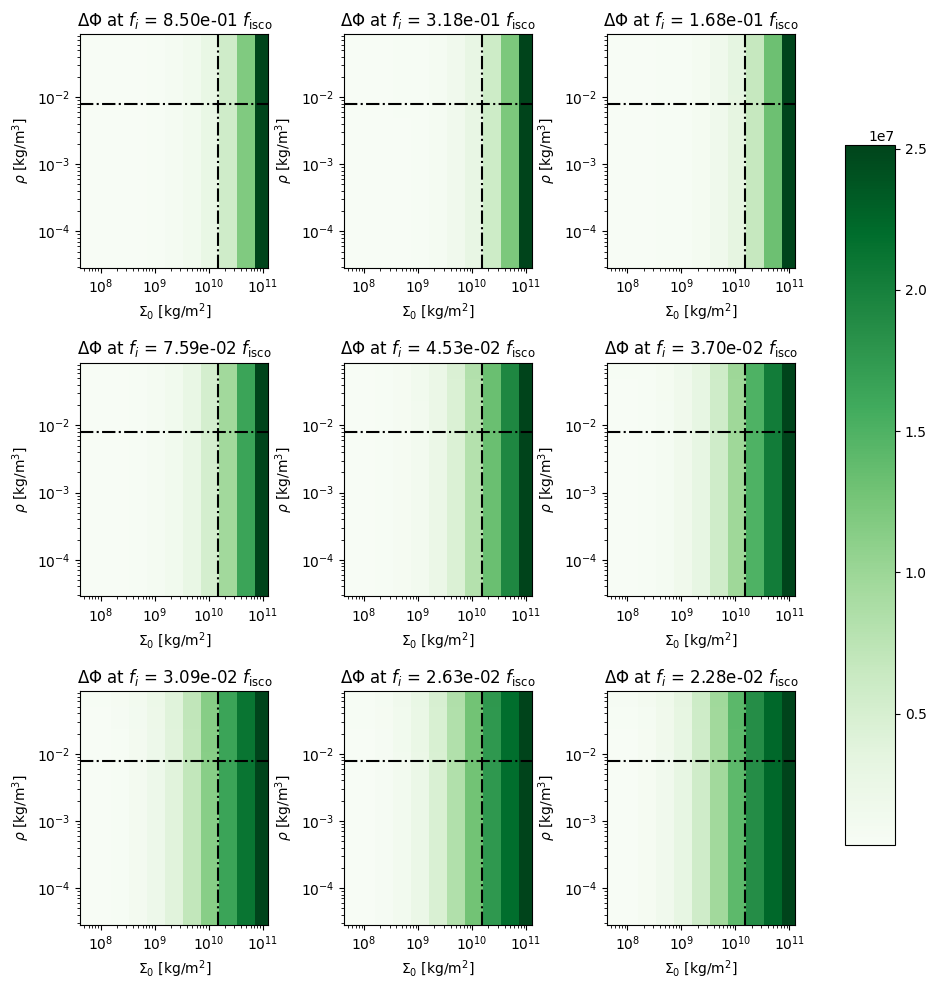

In [13]:
# Plot

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for ax, i in zip(axes.flat, n_comp_to_see):
    im = ax.pcolormesh(sigma_0, rho_s  * m_sun / (pc)**3, delta_all[:, :, i], cmap='Greens') # , clim=(1 * 1e10, 1.16 * 1e10)
    ax.axhline(y=1.17 * 1e17 * m_sun / (pc)**3, c='black', linestyle='-.', label='ref vals')
    ax.axvline(x=1.5 * 1e10, c='black', linestyle='-.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$\Sigma_0$ [kg/m$^2$]')
    ax.set_ylabel(r'$\rho$ [kg/m$^3$]')
    ax.set_title(f'$\Delta\Phi$ at $f_i$ = {freqs[i]/f_isco:.2e} $f_{{\mathrm{{isco}}}}$')
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('results-images/phi_DELTA_densities.png')

plt.show()

### $\alpha$ and $\gamma_s$

In [14]:
# Values selection

alpha = np.linspace(-0.7, 1.5, 10)
gamma_s = np.linspace(1, 3, 10)

In [15]:
phase_model_gammas = [[(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    alpha = alpha[i], 
    gammas = gamma_s[j], 
    rho6 =  1.17 * 1e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(alpha))] for j in range(0, len(gamma_s))] 

### Phase to coalescence

In [16]:
phi_all_gamma = [[(phase_model_gammas[i][j].phase_f_by_hand_all(r_grid)) for i in range(0, len(phase_model_gammas))] for j in range(0, len(phase_model_gammas))]
phi_dm_gamma = [[(phase_model_gammas[i][j].phase_f_by_hand_dm(r_grid)) for i in range(0, len(phase_model_gammas))] for j in range(0, len(phase_model_gammas))]
phi_acc_gamma = [[(phase_model_gammas[i][j].phase_f_by_hand_acc(r_grid)) for i in range(0, len(phase_model_gammas))] for j in range(0, len(phase_model_gammas))]
phi_gw_gamma = [[(phase_model_gammas[i][j].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_gammas))]  for j in range(0, len(phase_model_gammas))]

In [17]:
phi_all_gamma = np.array(phi_all_gamma)
phi_dm_gamma = np.array(phi_dm_gamma)
phi_gw_gamma = np.array(phi_gw_gamma)
phi_acc_gamma = np.array(phi_acc_gamma)

### Dephasing (in 2 $\pi$)

In [18]:
delta_all_g = phi_all_gamma - phi_gw_gamma
delta_acc_g = phi_acc_gamma - phi_gw_gamma
delta_dm_g = phi_dm_gamma - phi_gw_gamma

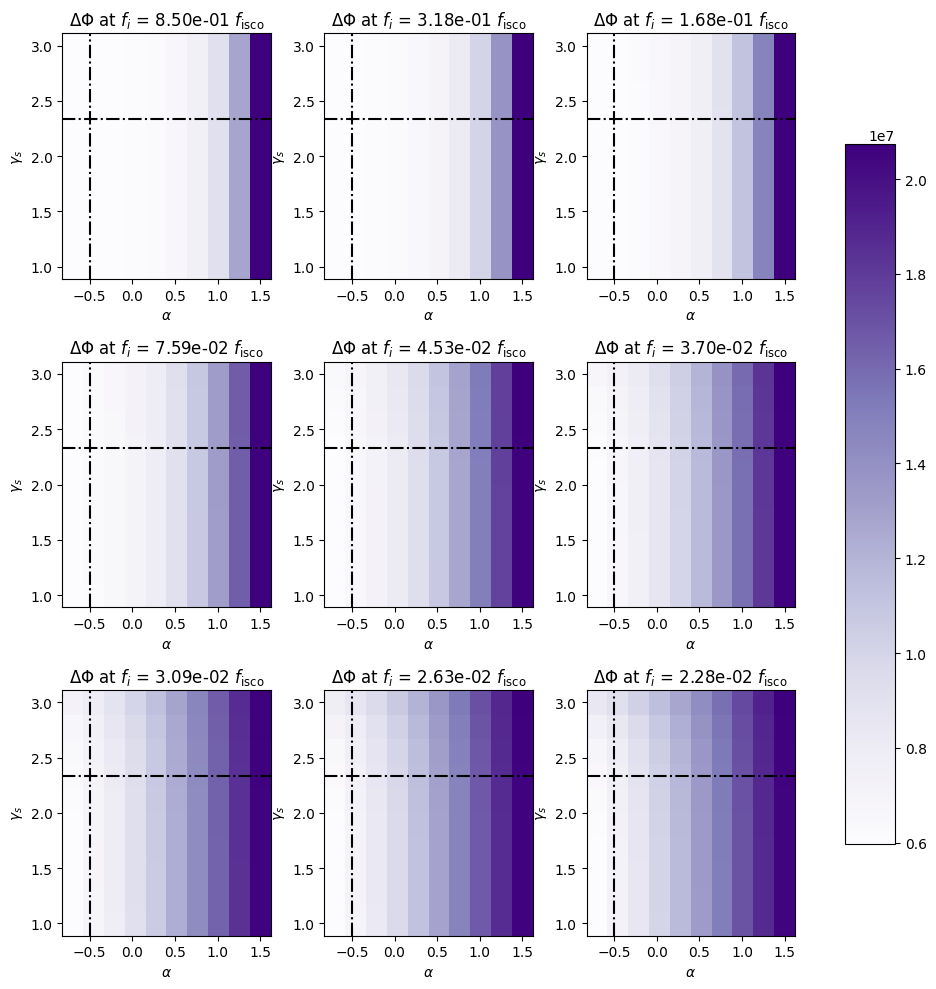

In [19]:
# Plots

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for ax, i in zip(axes.flat, n_comp_to_see):
    im = ax.pcolormesh(alpha, gamma_s, delta_all_g[:, :, i], cmap='Purples') # , clim=(1 * 1e10, 1.16 * 1e10)
    ax.axhline(y=7/3, c='black', linestyle='-.', label='ref vals')
    ax.axvline(x=-0.5,c='black', linestyle='-.',)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\gamma_s$')
    ax.set_title(f'$\Delta\Phi$ at $f_i$ = {freqs[i]/f_isco:.2e} $f_{{\mathrm{{isco}}}}$')
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('results-images/phi_DELTA_gammas.png')

plt.show()

---

# Section 3: Understand the threshold in the data

The goal now is start from these plots and carry ou the following analysis in steps: 

- Fix a value for one of the quantities on the axes (for example $\gamma$); 
- Check which of the other non-selected value on the secondary axis corresponds to $\Delta\Phi < 1$; 

The final shape will determine the threshold for a given value of the parameter $\gamma$ fixed. I think I will start by fixing the first parameters to the reference values.

In [20]:
delta_all_g.shape

(10, 10, 1000)

I'll start with $\gamma$. The reference value is $\gamma = -0.5$, corresponding to the first component of the $\texttt{delta_all_g}$ tensor. I loop on the values of $\gamma_s$ at a fixed frequency to find the threshold value for $\Delta\Phi < 1$.  

In [21]:
n_comp_to_see_closer = list(range(1, 21)) #[1, 10, 20] # only close to ISCO frequencies work

In [22]:
def find_threshold(param_2_array, phase_value):
    
    '''Takes as an argument the phase value at a fixed frequency, and a fixed parameter of two (shape = [n_components_parameter2])
    Returns the optimal value if found to satisfy condition, else the first element of array & error message.'''
    
    cutoff = np.where(phase_value / (2 * np.pi) < 1)[0]
    
    if cutoff.size == 0:
        
        print('No optimal value found --> returning first component of params array.')
        
        return param_2_array[0]
    
    cutoff = np.where(phase_value / (2 * np.pi) < 1)[0][-1]
    
    return param_2_array[cutoff]

## Fix $\alpha$, find $\gamma_s$

In [23]:
gamma_s_optimal = [find_threshold(gamma_s, delta_all_g[0, :, i]) for i in n_comp_to_see_closer]

### Note:

One can see how the treshold is getting smaller as the frequencies are increasing, so for the sake of representation I chose to only plot the "maximal" threshold in which all the others are encapsuled.

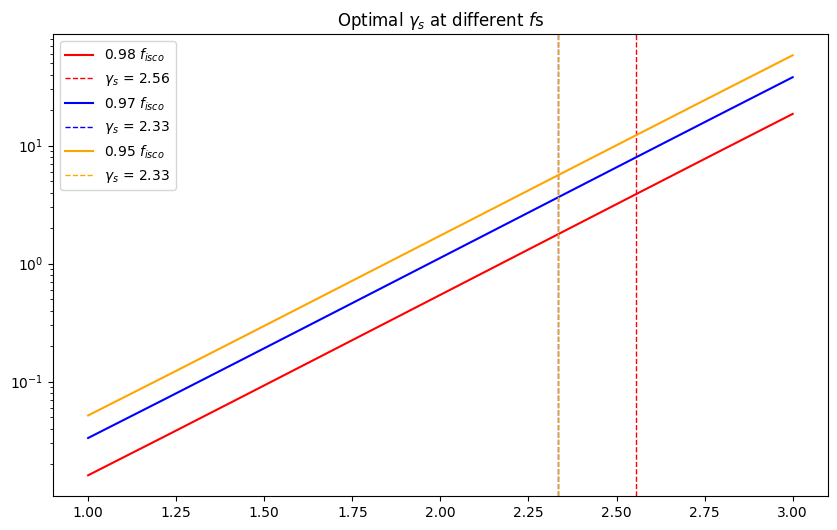

In [24]:
colors = ['red', 'blue', 'orange']

plt.figure(figsize=(10, 6))

for i in range(0, len(n_comp_to_see_closer[:3])):

    plt.semilogy(gamma_s, delta_all_g[0, :, n_comp_to_see_closer[i]], label=f'{freqs[n_comp_to_see_closer[i]]/f_isco :.2f} $f_{{isco}}$', c=colors[i])
    plt.axvline(x=gamma_s_optimal[i], linestyle='--', linewidth=1, label=f'$\gamma_s$ = {gamma_s_optimal[i]:.2f}', c=colors[i])
    
plt.legend()
plt.title('Optimal $\gamma_s$ at different $f$s')
plt.show()

### Results for $\gamma_s$

I think it is better to print out a table with the values with this format: 


$$|| \ \ \text{freqs} \ \ || \ \ \gamma_s \ \ ||$$

In [25]:
data = []
for i in range(len(freqs[n_comp_to_see_closer])):
    data.append(["{:.2f}".format(freqs[n_comp_to_see_closer][i]/f_isco), "{:.2f}".format(gamma_s_optimal[i])])

# Define headers for the table
headers = ['f/f_isco', 'opt gamma_s']

# Print the table using the tabulate function
print(tabulate(data, headers=headers, tablefmt="pretty").center(100))

+----------+-------------+
| f/f_isco | opt gamma_s |
+----------+-------------+
|   0.98   |    2.56     |
|   0.97   |    2.33     |
|   0.95   |    2.33     |
|   0.94   |    2.11     |
|   0.92   |    2.11     |
|   0.91   |    2.11     |
|   0.89   |    1.89     |
|   0.88   |    1.89     |
|   0.86   |    1.89     |
|   0.85   |    1.89     |
|   0.84   |    1.89     |
|   0.82   |    1.89     |
|   0.81   |    1.67     |
|   0.80   |    1.67     |
|   0.79   |    1.67     |
|   0.78   |    1.67     |
|   0.77   |    1.67     |
|   0.76   |    1.67     |
|   0.74   |    1.67     |
|   0.73   |    1.67     |
+----------+-------------+


Having too little points to plot histogram, I plot the optimal values given a frequency:

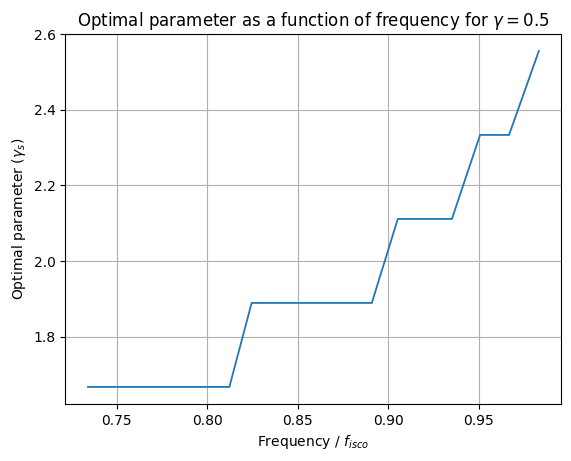

In [26]:
plt.plot(freqs[n_comp_to_see_closer] / f_isco, gamma_s_optimal, linewidth=1.3)
plt.title('Optimal parameter as a function of frequency for $\gamma = 0.5$')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel('Optimal parameter ($\gamma_s$)')
plt.grid(True)  # Add grid lines for better readability
plt.show()

## Fix $\gamma_s$, find $\alpha$

In [27]:
gamma_s # 6 index

array([1.        , 1.22222222, 1.44444444, 1.66666667, 1.88888889,
       2.11111111, 2.33333333, 2.55555556, 2.77777778, 3.        ])

In [28]:
alpha_optimal = [find_threshold(alpha, delta_all_g[:, 6, i]) for i in n_comp_to_see_closer]

No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value fou

### Results for $\alpha$

In [29]:
data = []
for i in range(len(freqs[n_comp_to_see_closer])):
    data.append(["{:.2f}".format(freqs[n_comp_to_see_closer][i]/f_isco), "{:.2f}".format(alpha_optimal[i])])

# Define headers for the table
headers = ['f/f_isco', 'opt alpha']

# Print the table using the tabulate function
print(tabulate(data, headers=headers, tablefmt="pretty").center(100))

+----------+-----------+
| f/f_isco | opt alpha |
+----------+-----------+
|   0.98   |   1.50    |
|   0.97   |   1.50    |
|   0.95   |   1.50    |
|   0.94   |   -0.70   |
|   0.92   |   -0.70   |
|   0.91   |   -0.70   |
|   0.89   |   -0.70   |
|   0.88   |   -0.70   |
|   0.86   |   -0.70   |
|   0.85   |   -0.70   |
|   0.84   |   -0.70   |
|   0.82   |   -0.70   |
|   0.81   |   -0.70   |
|   0.80   |   -0.70   |
|   0.79   |   -0.70   |
|   0.78   |   -0.70   |
|   0.77   |   -0.70   |
|   0.76   |   -0.70   |
|   0.74   |   -0.70   |
|   0.73   |   -0.70   |
+----------+-----------+


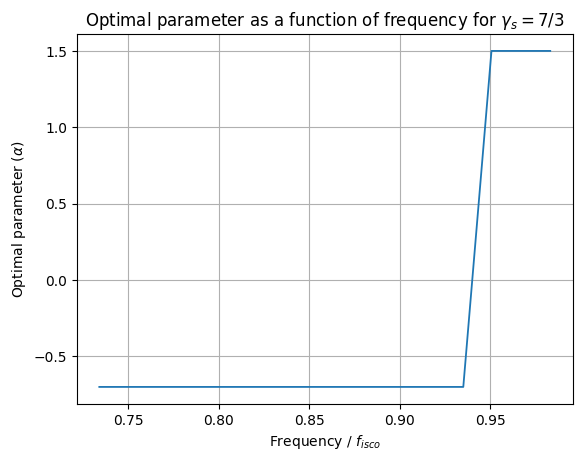

In [30]:
plt.plot(freqs[n_comp_to_see_closer] / f_isco, alpha_optimal, linewidth=1.3)
plt.title('Optimal parameter as a function of frequency for $\gamma_s = 7/3$')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel(r'Optimal parameter ($\alpha$)')
plt.grid(True)  # Add grid lines for better readability
plt.show()

## Fix $\Sigma_0$, vary $\rho_{\mathrm{dm}}$

In [31]:
sigma_0 # 6 index

array([1.00000000e+08, 2.15443469e+08, 4.64158883e+08, 1.00000000e+09,
       2.15443469e+09, 4.64158883e+09, 1.00000000e+10, 2.15443469e+10,
       4.64158883e+10, 1.00000000e+11])

In [32]:
rho_dm_optimal = [find_threshold(rho_s, delta_all[6, :, i]) for i in n_comp_to_see_closer]

### Results for $\Sigma_0$

In [33]:
data = []
for i in range(len(freqs[n_comp_to_see_closer])):
    data.append(["{:.2f}".format(freqs[n_comp_to_see_closer][i]/f_isco), "{:.2e}".format(rho_dm_optimal[i])])

# Define headers for the table
headers = ['f/f_isco', 'opt rho_dm']

# Print the table using the tabulate function
print(tabulate(data, headers=headers, tablefmt="pretty").center(100))

+----------+------------+
| f/f_isco | opt rho_dm |
+----------+------------+
|   0.98   |  2.15e+17  |
|   0.97   |  1.00e+17  |
|   0.95   |  1.00e+17  |
|   0.94   |  4.64e+16  |
|   0.92   |  4.64e+16  |
|   0.91   |  4.64e+16  |
|   0.89   |  4.64e+16  |
|   0.88   |  2.15e+16  |
|   0.86   |  2.15e+16  |
|   0.85   |  2.15e+16  |
|   0.84   |  2.15e+16  |
|   0.82   |  2.15e+16  |
|   0.81   |  2.15e+16  |
|   0.80   |  1.00e+16  |
|   0.79   |  1.00e+16  |
|   0.78   |  1.00e+16  |
|   0.77   |  1.00e+16  |
|   0.76   |  1.00e+16  |
|   0.74   |  1.00e+16  |
|   0.73   |  1.00e+16  |
+----------+------------+


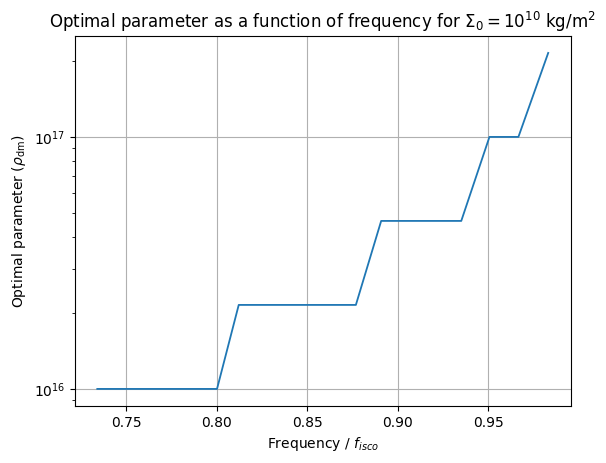

In [34]:
plt.semilogy(freqs[n_comp_to_see_closer] / f_isco, rho_dm_optimal, linewidth=1.3)
plt.title('Optimal parameter as a function of frequency for $\Sigma_0 = 10^{10}$ kg/m$^2$')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel(r'Optimal parameter ($\rho_{\mathrm{dm}}$)')
plt.grid(True)  # Add grid lines for better readability
plt.show()

## Fix $\rho_{\mathrm{dm}}$, vary $\Sigma_0$

In [35]:
sigma_0_optimal = [find_threshold(sigma_0, delta_all[:, 6, i]) for i in n_comp_to_see_closer]

No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value fou

### Results for $\rho_{dm}$

In [36]:
data = []
for i in range(len(freqs[n_comp_to_see_closer])):
    data.append(["{:.2f}".format(freqs[n_comp_to_see_closer][i]/f_isco), "{:.2e}".format(sigma_0_optimal[i])])

# Define headers for the table
headers = ['f/f_isco', 'opt sigma_0']

# Print the table using the tabulate function
print(tabulate(data, headers=headers, tablefmt="pretty").center(100))

+----------+-------------+
| f/f_isco | opt sigma_0 |
+----------+-------------+
|   0.98   |  1.00e+11   |
|   0.97   |  1.00e+11   |
|   0.95   |  1.00e+11   |
|   0.94   |  1.00e+08   |
|   0.92   |  1.00e+08   |
|   0.91   |  1.00e+08   |
|   0.89   |  1.00e+08   |
|   0.88   |  1.00e+08   |
|   0.86   |  1.00e+08   |
|   0.85   |  1.00e+08   |
|   0.84   |  1.00e+08   |
|   0.82   |  1.00e+08   |
|   0.81   |  1.00e+08   |
|   0.80   |  1.00e+08   |
|   0.79   |  1.00e+08   |
|   0.78   |  1.00e+08   |
|   0.77   |  1.00e+08   |
|   0.76   |  1.00e+08   |
|   0.74   |  1.00e+08   |
|   0.73   |  1.00e+08   |
+----------+-------------+


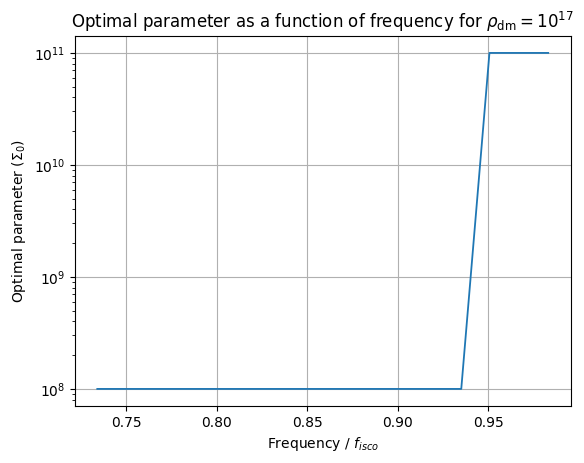

In [37]:
plt.semilogy(freqs[n_comp_to_see_closer] / f_isco, sigma_0_optimal, linewidth=1.3)
plt.title(r'Optimal parameter as a function of frequency for $\rho_{\mathrm{dm}} = 10^{17}$')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel(r'Optimal parameter ($\Sigma_0$)')
plt.grid(True)  # Add grid lines for better readability
plt.show()

## Checking the accretion parameters change with respect to dark matter ones

The accretion optimal parameters seem to be okay in detection with respect to fixed reference values of the dark matter profile. However, I want to check if changing the dark matter's density to larger or lower values affects this behavior. 

In [38]:
# Create array for each evaluation

alpha_optimal_i = np.array([[find_threshold(alpha, delta_all_g[:, j, i]) for i in n_comp_to_see_closer] for j in range(0, len(gamma_s))])

No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value fou

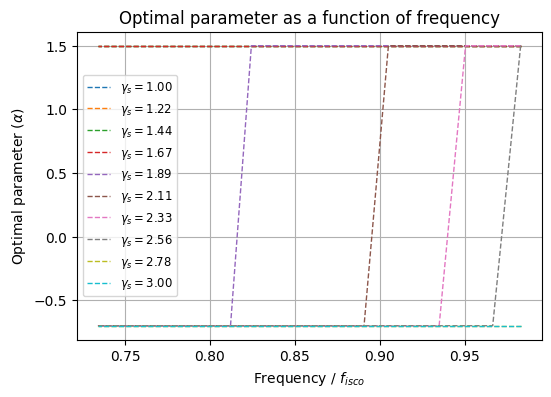

In [39]:
plt.figure(figsize=(6, 4))

for i in range(0, len(alpha_optimal_i)):

    plt.plot(freqs[n_comp_to_see_closer] / f_isco, alpha_optimal_i[i], linewidth=1, label=f'$\gamma_s = {gamma_s[i]:.2f}$', linestyle='--')
    
plt.title(r'Optimal parameter as a function of frequency')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel(r'Optimal parameter ($\alpha$)')
plt.grid(True)  # Add grid lines for better readability
plt.legend(fontsize='small')
plt.show()

In [40]:
# Create array for each evaluation

sigma_0_optimal_i = [[find_threshold(sigma_0, delta_all_g[:, j, i]) for i in n_comp_to_see_closer] for j in range(0, len(rho_s))]

No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value found --> returning first component of params array.
No optimal value fou

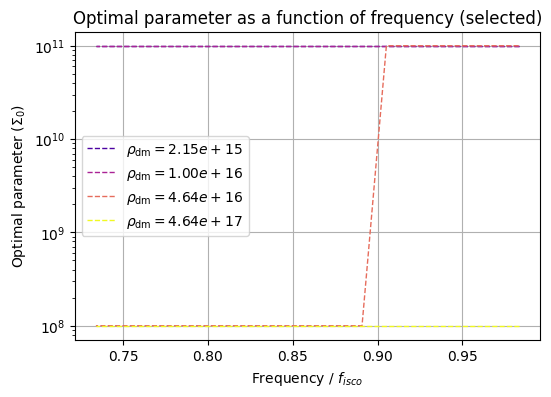

In [41]:
cmap = plt.get_cmap('plasma')
selected_vals = [1, 3, 5, 8]

plt.figure(figsize=(6, 4))

for i in selected_vals:
    
    color = cmap(0.5 * i / len(alpha_optimal_i[selected_vals])) 
    plt.plot(freqs[n_comp_to_see_closer] / f_isco, sigma_0_optimal_i[i], linewidth=1, linestyle='--', label=fr'$\rho_{{\mathrm{{dm}}}} = {rho_s[i]:.2e}$', color=color)
    
plt.title(r'Optimal parameter as a function of frequency (selected)')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel(r'Optimal parameter ($\Sigma_0$)')
plt.yscale('log')
plt.grid(True)  # Add grid lines for better readability
plt.legend(fontsize='medium')
plt.show()

---

## Find the value of the dephasing at a given frequency depending on one parameter, fixing the others

Do some other verifications: visualize the values of the dephasing at a given frequency, changing one of the parameters value (e.g. one of the lines present in the meshgrid plots).

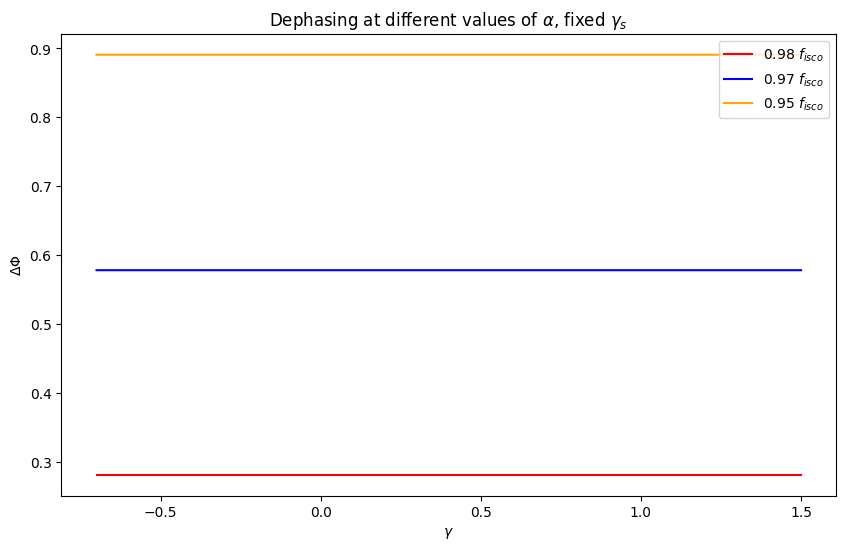

In [42]:
colors = ['red', 'blue', 'orange']

plt.figure(figsize=(10, 6))

for i in range(0, len(n_comp_to_see_closer[:3])):

    plt.plot(alpha, delta_all_g[:, 6, n_comp_to_see_closer[i]]/(2 * np.pi), label=f'{freqs[n_comp_to_see_closer[i]]/f_isco :.2f} $f_{{isco}}$', c=colors[i])
    
plt.xlabel('$\gamma$')
plt.ylabel('$\Delta\Phi$')
plt.legend()
plt.title(r'Dephasing at different values of $\alpha$, fixed $\gamma_s$')
plt.savefig('results-images/dephasing-test-gamma.png')
plt.show()

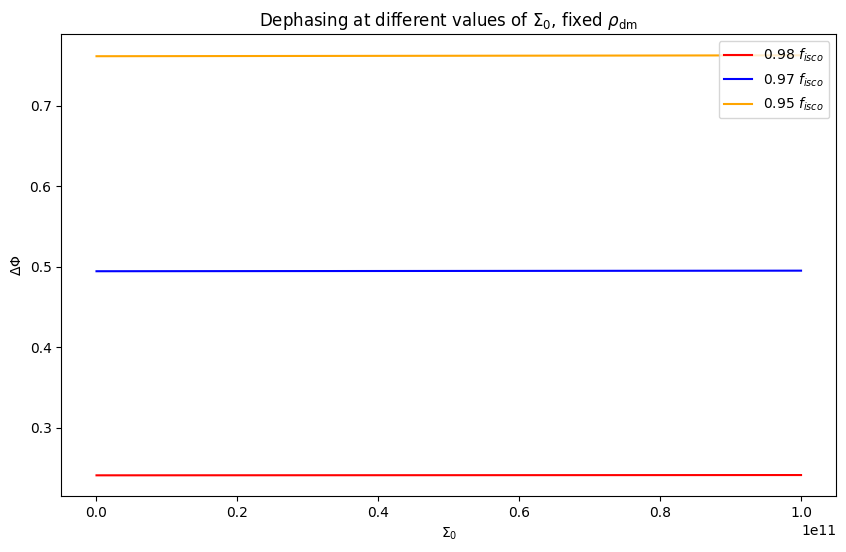

In [43]:
colors = ['red', 'blue', 'orange']

plt.figure(figsize=(10, 6))

for i in range(0, len(n_comp_to_see_closer[:3])):

    plt.plot(sigma_0, delta_all[:, 6, n_comp_to_see_closer[i]]/(2 * np.pi), label=f'{freqs[n_comp_to_see_closer[i]]/f_isco :.2f} $f_{{isco}}$', c=colors[i])
    
plt.xlabel('$\Sigma_0$')
plt.ylabel('$\Delta\Phi$')
plt.legend()
plt.title(r'Dephasing at different values of $\Sigma_0$, fixed $\rho_{\mathrm{dm}}$')
plt.savefig('results-images/dephasing-test-sigma_0.png')
plt.show()

---

## Changing completely the order of magnitude of the dark matter density

It seems that if we fix the value for the dark matter spike, the change on the dephasing given by the accretion disk is relatively small for a fixed frequency close to ISCO. Let's try to change the value of the dark matter spike density normalization by more orders of magnitude, possibly tuning it down to increase the net effect of the accretion disk onto the dephasing. 

In [44]:
rho_s_2 = np.logspace(8, 14, 10)

In [45]:
phase_model_dense_1 = [[(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = sigma_0[i], 
    alpha = -1/2, 
    gammas = 7/3, 
    rho6 = rho_s_2[j] * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(sigma_0))] for j in range(0, len(rho_s_2))] 

In [46]:
# Calculate phase 

phi_all_dense_1 = [[(phase_model_dense_1[i][j].phase_f_by_hand_all(r_grid)) for i in range(0, len(phase_model_dense_1))] for j in range(0, len(phase_model_dense_1))]
phi_gw_dense_1 = [[(phase_model_dense_1[i][j].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_dense_1))]  for j in range(0, len(phase_model_dense_1))]

In [47]:
# Dephasing

delta_all_1 = np.array(phi_all_dense_1) - np.array(phi_gw_dense_1)

In [48]:
n_comp_to_see_closer

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [49]:
# Calculate the optimal parameter

n_comp_to_see_closer_1 = list(range(1, 100))
sigma_0_optimal_i_1 = np.array([[find_threshold(sigma_0, delta_all_1[:, j, i]) for i in n_comp_to_see_closer_1] for j in range(0, len(rho_s_2))])

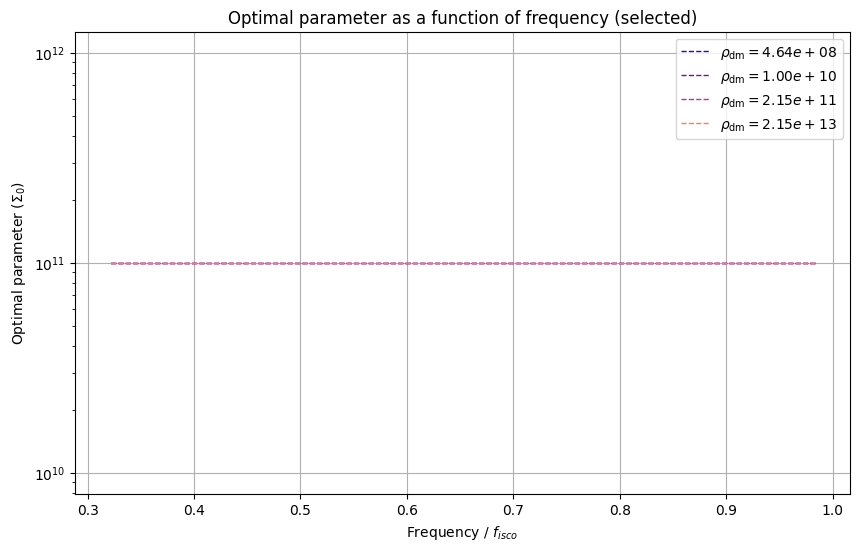

In [50]:
# See the results for fixed density_dm

cmap = plt.get_cmap('plasma')
selected_vals = [1, 3, 5, 8]

plt.figure(figsize=(10, 6))

for i in selected_vals:
    
    color = cmap(0.35 * i / len(sigma_0_optimal_i_1[selected_vals])) 
    plt.plot(freqs[n_comp_to_see_closer_1] / f_isco, sigma_0_optimal_i_1[i], linewidth=1, linestyle='--', label=fr'$\rho_{{\mathrm{{dm}}}} = {rho_s_2[i]:.2e}$', color=color)
    
plt.title(r'Optimal parameter as a function of frequency (selected)')
plt.xlabel('Frequency / $f_{isco}$')
plt.ylabel(r'Optimal parameter ($\Sigma_0$)')
plt.yscale('log')
plt.grid(True)  # Add grid lines for better readability
plt.legend(fontsize='medium')
plt.show()

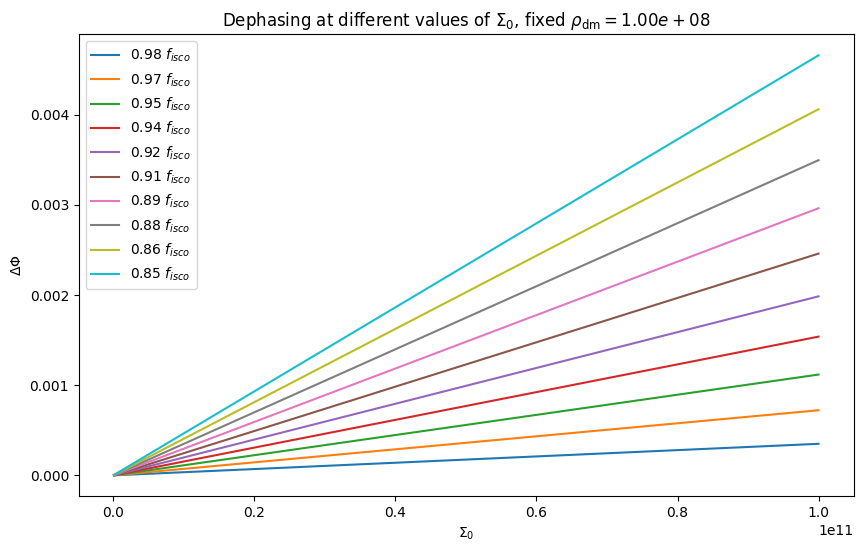

In [51]:
colors = ['red', 'blue', 'orange']

plt.figure(figsize=(10, 6))

selected_density = 0

for i in range(0, len(n_comp_to_see_closer_1[::10])):

    plt.plot(sigma_0, delta_all_1[:, selected_density, n_comp_to_see_closer_1[i]]/(2 * np.pi), label=fr'{freqs[n_comp_to_see_closer_1[i]]/f_isco :.2f} $f_{{isco}}$')
    
plt.xlabel('$\Sigma_0$')
plt.ylabel('$\Delta\Phi$')
plt.legend()
plt.title(fr'Dephasing at different values of $\Sigma_0$, fixed $\rho_{{\mathrm{{dm}}}} = {rho_s_2[selected_density]:.2e}$')
plt.show()

What it seems from here is that if the dark matter spike is not present, we never have a chance of detecting the accretion disk on its own, even if the spike has a considerably low density profile as $10^{-8}$ $M_{\odot}$/Mpc$^3$. I think that we probably have to consider an environment where the accretion disk is very very dense, or it won't be detectable at all. 

---

## Detection time treshold

The idea that is in the below lines is the following: for a specific environment, e.g. only accretion, or only dark matter, I evaluate the $f_{\mathrm{thresh}}$ at different parameters values (for example change $\Sigma_0$, or $\rho_{\mathrm{dm}}$). This is the frequency at which I see that the dephasing value is such that $\Delta\Phi < 1$. I then plot for each parameter value the time until which I expect to be able to spot the difference with the vacuum case.  

### Accretion disk

- Start with $\Sigma_0$.

In [52]:
def time_to_coal_acc(phase_model, r, f_lower_lim):
    
    to_integrate = (phase_model.df_dt_acc(r))**-1
    
    f_range = freqs[freqs >= f_lower_lim]
    
    return np.trapz(to_integrate[:len(f_range)], x=f_range)

In [53]:
phase_model_dense_2 = [(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = sigma_0[i], 
    alpha = -1/2, 
    gammas = 7/3, 
    rho6 = 1.5e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(sigma_0))] 

In [54]:
phi_acc_dense_2 = np.array([(phase_model_dense_2[i].phase_f_by_hand_acc(r_grid)) for i in range(0, len(phase_model_dense_2))])
phi_gw_dense_2 = np.array([(phase_model_dense_2[i].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_dense_2))])

In [55]:
delta_acc_2 = phi_acc_dense_2 - phi_gw_dense_2

In [56]:
def find_threshold_freq(freqs, phase_value):
    
    '''Takes as an argument the phase value at a fixed frequency, and a fixed parameter of two (shape = [n_components_parameter2])
    Returns the optimal value if found to satisfy condition, else the first element of array & error message.'''
    
    cutoff = np.where(phase_value / (2 * np.pi) < 1)[0]
    
    if cutoff.size == 0:
        
        print('No optimal value found --> returning first component of data array.')
        
        return phase_value[0]
    
    cutoff = np.where(phase_value / (2 * np.pi) < 1)[0][-1]
    
    return freqs[cutoff]

In [57]:
freqs_detection = np.array([find_threshold_freq(freqs, delta_acc_2[i]) for i in range(0, len(delta_acc_2))])

In [58]:
time_to_coal_dense = [time_to_coal_acc(phase_model_dense_2[i], r_grid, freqs_detection[i]) for i in range(0, len(phase_model_dense_2))]

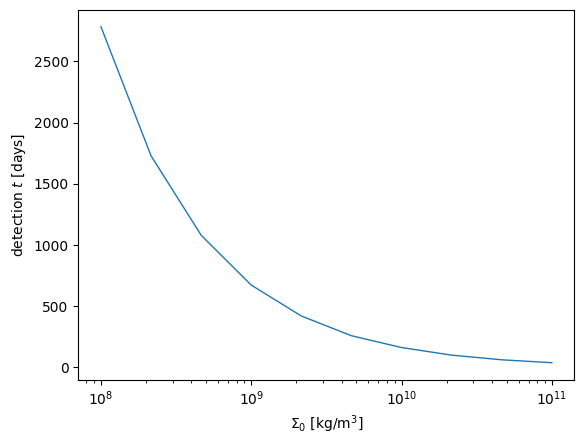

In [59]:
plt.semilogx(sigma_0, -np.array(time_to_coal_dense) * 1.15741e-5, linestyle='-', linewidth=1)

plt.xlabel('$\Sigma_0$ [kg/m$^3$]')
plt.ylabel('detection $t$ [days]')
plt.show()

- Continue with $\gamma$.

In [60]:
phase_model_gamma_2 = [(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    alpha = alpha[i], 
    gammas = 7/3, 
    rho6 = 1.5e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(alpha))] 

In [61]:
phi_acc_gamma_2 = np.array([(phase_model_gamma_2[i].phase_f_by_hand_acc(r_grid)) for i in range(0, len(phase_model_gamma_2))])
phi_gw_gamma_2 = np.array([(phase_model_gamma_2[i].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_gamma_2))])

In [62]:
delta_gamma_2 = phi_acc_gamma_2 - phi_gw_gamma_2

In [63]:
freqs_detection_gamma = np.array([find_threshold_freq(freqs, delta_gamma_2[i]) for i in range(0, len(delta_gamma_2))])

In [64]:
time_to_coal_gamma = [time_to_coal_acc(phase_model_gamma_2[i], r_grid, freqs_detection_gamma[i]) for i in range(0, len(phase_model_gamma_2))]

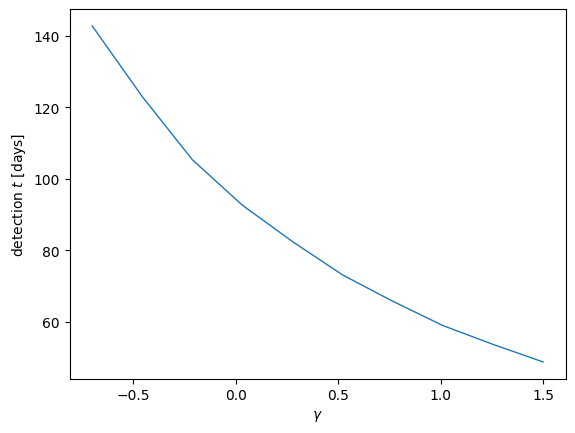

In [65]:
plt.plot(alpha, -np.array(time_to_coal_gamma) * 1.15741e-5, linestyle='-', linewidth=1)

plt.xlabel('$\gamma$')
plt.ylabel('detection $t$ [days]')
plt.show()

### Dark matter

- Start with $\rho_{\mathrm{DM}}$

In [66]:
def time_to_coal_dm(phase_model, r, f_lower_lim):
    
    to_integrate = (phase_model.df_dt_dm(r))**-1
    
    f_range = freqs[freqs >= f_lower_lim]
    
    return np.trapz(to_integrate[:len(f_range)], x=f_range)

In [67]:
phase_model_dense_dm_2 = [(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    alpha = -1/2, 
    gammas = 7/3, 
    rho6 = rho_s[i] * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(rho_s))] 

In [68]:
phi_dense_dm_2 = np.array([(phase_model_dense_dm_2[i].phase_f_by_hand_dm(r_grid)) for i in range(0, len(phase_model_dense_dm_2))])
phi_gw_dense_dm_2 = np.array([(phase_model_dense_dm_2[i].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_dense_dm_2))])

In [69]:
delta_dense_dm_2 = phi_dense_dm_2 - phi_gw_dense_dm_2

In [70]:
freqs_detection_density_dm = np.array([find_threshold_freq(freqs, delta_dense_dm_2[i]) for i in range(0, len(delta_dense_dm_2))])

In [71]:
time_to_coal_dense_dm = [time_to_coal_dm(phase_model_dense_dm_2[i], r_grid, freqs_detection_density_dm[i]) for i in range(0, len(phase_model_dense_dm_2))]

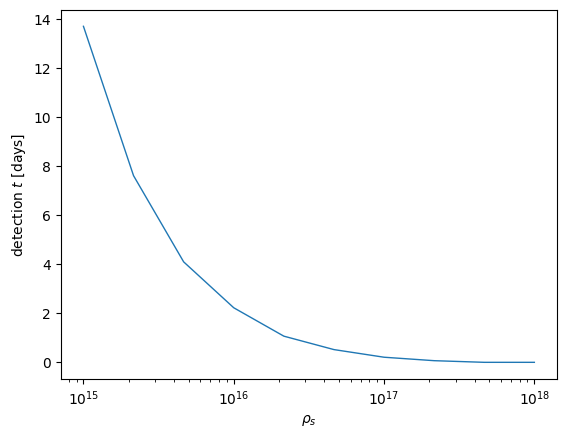

In [72]:
plt.semilogx(rho_s, -np.array(time_to_coal_dense_dm) * 1.15741e-5, linestyle='-', linewidth=1)

plt.xlabel(r'$\rho_s$')
plt.ylabel('detection $t$ [days]')
plt.show()

- Continue with $\gamma_s$

In [73]:
phase_model_gammas_2 = [(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    alpha = -1/2, 
    gammas = gamma_s[i], 
    rho6 = 1.5e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(gamma_s))] 

In [74]:
phi_gammas_dm_2 = np.array([(phase_model_gammas_2[i].phase_f_by_hand_dm(r_grid)) for i in range(0, len(phase_model_gammas_2))])
phi_gw_gammas_dm_2 = np.array([(phase_model_gammas_2[i].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_gammas_2))])

In [75]:
delta_gammas_dm_2 = phi_gammas_dm_2  - phi_gw_gammas_dm_2

In [76]:
freqs_detection_gammas_dm = np.array([find_threshold_freq(freqs, delta_gammas_dm_2[i]) for i in range(0, len(delta_gammas_dm_2))])

In [77]:
time_to_coal_gammas_dm = [time_to_coal_dm(phase_model_gammas_2[i], r_grid, freqs_detection_gammas_dm[i]) for i in range(0, len(phase_model_gammas_2))]

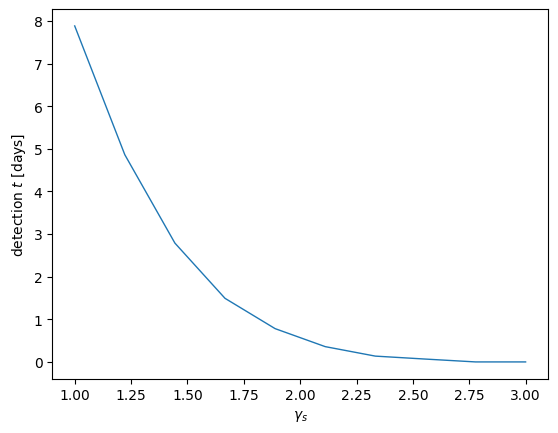

In [78]:
plt.plot(gamma_s, -np.array(time_to_coal_gammas_dm) * 1.15741e-5, linestyle='-', linewidth=1)

plt.xlabel(r'$\gamma_s$')
plt.ylabel('detection $t$ [days]')
plt.show()

# Section 4: Find the benchmark value for $\rho_{\mathrm{dm}}$

In [79]:
rho_bench_to_scan = np.logspace(5, 18, 50)
print(rho_bench_to_scan)

[1.00000000e+05 1.84206997e+05 3.39322177e+05 6.25055193e+05
 1.15139540e+06 2.12095089e+06 3.90693994e+06 7.19685673e+06
 1.32571137e+07 2.44205309e+07 4.49843267e+07 8.28642773e+07
 1.52641797e+08 2.81176870e+08 5.17947468e+08 9.54095476e+08
 1.75751062e+09 3.23745754e+09 5.96362332e+09 1.09854114e+10
 2.02358965e+10 3.72759372e+10 6.86648845e+10 1.26485522e+11
 2.32995181e+11 4.29193426e+11 7.90604321e+11 1.45634848e+12
 2.68269580e+12 4.94171336e+12 9.10298178e+12 1.67683294e+13
 3.08884360e+13 5.68986603e+13 1.04811313e+14 1.93069773e+14
 3.55648031e+14 6.55128557e+14 1.20679264e+15 2.22299648e+15
 4.09491506e+15 7.54312006e+15 1.38949549e+16 2.55954792e+16
 4.71486636e+16 8.68511374e+16 1.59985872e+17 2.94705170e+17
 5.42867544e+17 1.00000000e+18]


In [80]:
phase_model_bench = [(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5e10, 
    alpha = -1/2, 
    gammas = 7/3, 
    rho6 = rho_bench_to_scan[i] * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(rho_bench_to_scan))]

### Phase to coalescence

In [81]:
phi_all_bench = np.array([(phase_model_bench[i].phase_f_by_hand_all(r_grid)) for i in range(0, len(phase_model_bench))])
phi_gw_bench = np.array([(phase_model_bench[i].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_bench))])

### Dephasing (in 2 $\pi$)

In [82]:
delta_bench = phi_all_bench  - phi_gw_bench

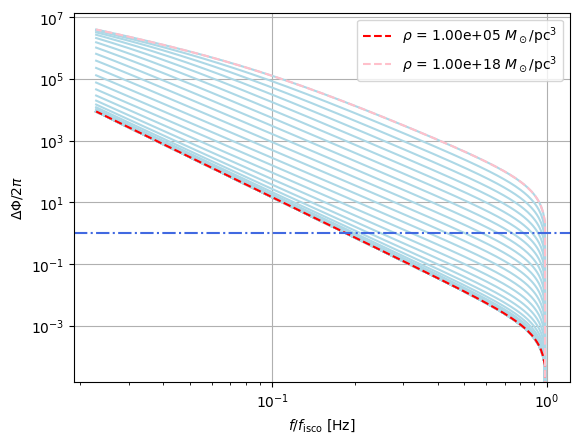

In [83]:
for i in range(0, len(delta_bench)):
    
    plt.loglog(freqs/f_isco, delta_bench[i]/(2 * np.pi), c='lightblue')
    
plt.loglog(freqs/f_isco, delta_bench[0]/(2 * np.pi), label=fr'$\rho$ = {rho_bench_to_scan[0]:.2e} $M_\odot / \mathrm{{pc}}^3$', c='red', linestyle='--')
plt.loglog(freqs/f_isco, delta_bench[-1]/(2 * np.pi), label=fr'$\rho$ = {rho_bench_to_scan[-1]:.2e} $M_\odot / \mathrm{{pc}}^3$', c='pink', linestyle='--')
plt.axhline(y=1, c='royalblue', linestyle='-.')
plt.xlabel('$f/f_{\mathrm{isco}}$ [Hz]')
plt.ylabel('$\Delta\Phi / 2\pi$ ')
plt.grid(True)
plt.legend();

Let's extract the values of the optimal density normalization.

In [84]:
freq_bench = np.array([find_threshold_freq(freqs, delta_bench[i]) for i in range(0, len(delta_bench))])

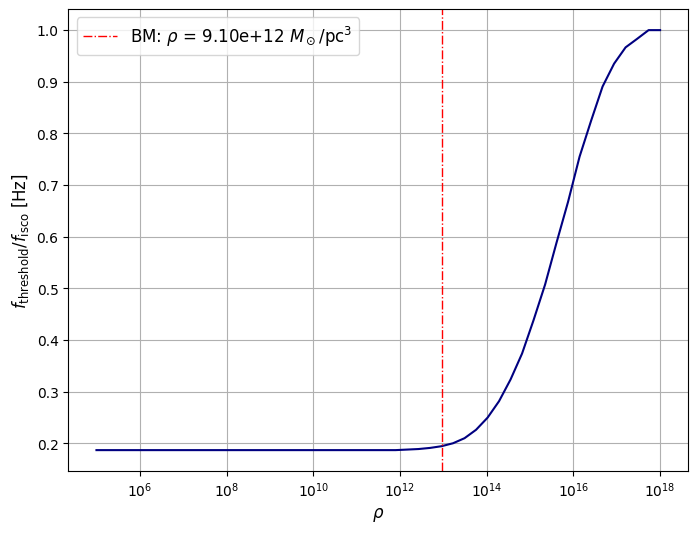

In [85]:
# Plot
plt.figure(figsize=(8, 6))

plt.semilogx(rho_bench_to_scan, freq_bench/f_isco, linestyle='-', color='navy')
plt.ylabel('$f_{\mathrm{threshold}}/f_{\mathrm{isco}}$ [Hz]', fontsize=12)
plt.xlabel(r'$\rho$ ', fontsize=12)
plt.grid(True)

benchmark = np.where(freq_bench/f_isco < 0.2)[0][-1]
plt.axvline(x=rho_bench_to_scan[benchmark], c='red', label=fr'BM: $\rho$ = {rho_bench_to_scan[benchmark]:.2e} $M_\odot / \mathrm{{pc}}^3$', linestyle='-.', linewidth=1)
plt.legend(fontsize='large')
plt.show()

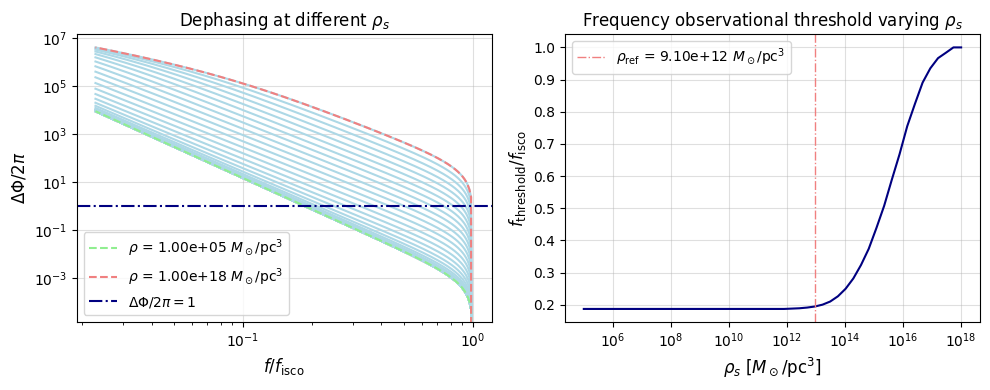

In [86]:
## For the notebook 

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i in range(0, len(delta_bench)):
    
    axs[0].loglog(freqs/f_isco, delta_bench[i]/(2 * np.pi), c='lightblue')
    
axs[0].loglog(freqs/f_isco, delta_bench[0]/(2 * np.pi), label=fr'$\rho$ = {rho_bench_to_scan[0]:.2e} $M_\odot / \mathrm{{pc}}^3$', c='lightgreen', linestyle='--')
axs[0].loglog(freqs/f_isco, delta_bench[-1]/(2 * np.pi), label=fr'$\rho$ = {rho_bench_to_scan[-1]:.2e} $M_\odot / \mathrm{{pc}}^3$', c='lightcoral', linestyle='--')
axs[0].axhline(y=1, c='navy', linestyle='-.', label='$\Delta\Phi / 2\pi = 1$')
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=12)
axs[0].set_ylabel('$\Delta\Phi / 2\pi$ ', fontsize=12)
axs[0].grid(True, alpha=0.4)
axs[0].set_title(r'Dephasing at different $\rho_s$')
axs[0].legend()

axs[1].semilogx(rho_bench_to_scan, freq_bench/f_isco, linestyle='-', color='navy')
axs[1].set_ylabel('$f_{\mathrm{threshold}}/f_{\mathrm{isco}}$', fontsize=12)
axs[1].set_xlabel(r'$\rho_s$ [$M_\odot / \mathrm{{pc}}^3$]', fontsize=12)
axs[1].set_title(r'Frequency observational threshold varying $\rho_s$')
axs[1].grid(True, alpha=0.4)

benchmark = np.where(freq_bench/f_isco < 0.2)[0][-1]
axs[1].axvline(x=rho_bench_to_scan[benchmark], c='lightcoral', label=fr'$\rho_{{\mathrm{{ref}}}}$ = {rho_bench_to_scan[benchmark]:.2e} $M_\odot / \mathrm{{pc}}^3$', linestyle='-.', linewidth=1)
axs[1].legend(fontsize='medium')

plt.tight_layout()
plt.savefig('results-images/benchmark_dm')
plt.show()